In [98]:
#!pip install --user -U nltk
#!pip install seaborn
#!pip install wordcloud

In [100]:
import pandas as pd
import nltk
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

tqdm.pandas()

# 1. Basic Text Pre-Processing

Basic text preprocessing steps include a few essential tasks to further clean the available text data. It includes tasks like:-

1. Stop-Word Removal
2. Lower Casing
3. Stemming
4. Tokenization

Pre-processing of the text is not the main objective of this notebook that's why I am just covering a few basic steps in a brief

In [81]:
df=pd.read_excel("compiled_tweets.xlsx", sheet_name="compiled_tweets")
df.head()

,Annotator1,Anonator2,Text,Subjectivity,Polarity,Subjectivity_Anonator2,Polarity_Anonator2
0,Jia Kai,Yiting,Hey Kingz Crew I Just Went Live On Twitch Come...,1.0,1.0,1.0,1.0
1,Jia Kai,Yiting,little bit of dbd into apex legends (: https:/...,0.0,NaN,0.0,0.0
2,Jia Kai,Yiting,Tuesday night apex?! Lets get some damage! htt...,1.0,1.0,1.0,1.0
3,Jia Kai,Yiting,Watch tohrmentgames GO CRAZY ON APEX!! FOLLOW ...,1.0,1.0,1.0,1.0
4,Jia Kai,Yiting,3...2...1.. ðŸ”´LIVE!ðŸ”´\nðŸ‘ï¸ðŸ‘„ðŸ‘ï¸\...,0.0,NaN,1.0,0.0


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11042 entries, 0 to 11041
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Annotator1              11042 non-null  object 
 1   Anonator2               11042 non-null  object 
 2   Text                    11042 non-null  object 
 3   Subjectivity            1061 non-null   float64
 4   Polarity                560 non-null    float64
 5   Subjectivity_Anonator2  871 non-null    float64
 6   Polarity_Anonator2      525 non-null    float64
dtypes: float64(4), object(3)
memory usage: 604.0+ KB


In [83]:
nltk.download('stopwords')
nltk.download('words')
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import SnowballStemmer 
from nltk.tokenize import RegexpTokenizer

stopwords = stopwords.words('english')
words = set(words.words())
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'\w+')
# As this dataset is fetched from twitter so it has lots of people tag in tweets
# we will remove them 
tags = r"@\w*"


def preprocess_text(sentence:str, stem = False):
    
    #sentence = [re.sub(tags, "", sentence)]
    text = []
    for w in nltk.wordpunct_tokenize(sentence):
        w=w.lower()
        if w not in stopwords:
            word = stemmer.stem(w).lower() if stem else w
            if word.lower() in words:
                text.append(word)
    return tokenizer.tokenize(" ".join(text))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [84]:
print(f"Orignal Text : {df.Text[11]}")
print()
print(f"Preprocessed Text : {preprocess_text(df.Text[11], stem=True)}")

Orignal Text : Please enjoy this Apex Legends â€œMemetageâ€ ðŸ˜‚ #ApexLedgends #ApexLegends https://t.co/1MhQCkMuoD

Preprocessed Text : ['enjoy', 'apex', 'legend']


In [85]:
df['ProcessedText']=df['Text'].progress_apply(lambda x: preprocess_text(x, stem=True))

100%|██████████| 11042/11042 [00:04<00:00, 2400.87it/s]


In [86]:
df.head(5)

,Annotator1,Anonator2,Text,Subjectivity,Polarity,Subjectivity_Anonator2,Polarity_Anonator2,ProcessedText
0,Jia Kai,Yiting,Hey Kingz Crew I Just Went Live On Twitch Come...,1.0,1.0,1.0,1.0,"[hey, crew, went, live, twitch, come, chat, ha..."
1,Jia Kai,Yiting,little bit of dbd into apex legends (: https:/...,0.0,NaN,0.0,0.0,"[bit, apex, legend]"
2,Jia Kai,Yiting,Tuesday night apex?! Lets get some damage! htt...,1.0,1.0,1.0,1.0,"[night, apex, let, get]"
3,Jia Kai,Yiting,Watch tohrmentgames GO CRAZY ON APEX!! FOLLOW ...,1.0,1.0,1.0,1.0,"[watch, go, apex, follow]"
4,Jia Kai,Yiting,3...2...1.. ðŸ”´LIVE!ðŸ”´\nðŸ‘ï¸ðŸ‘„ðŸ‘ï¸\...,0.0,NaN,1.0,0.0,"[live, hop, bit, come, want, wit, decent]"


In [88]:
df['Number_of_Words'] = df['ProcessedText'].apply(len)
print(f"{(df['Number_of_Words'] == 0).sum()} of tweets has 0 word")
processed_df = df[df['Number_of_Words'] > 0].copy()
# drop the tweets with 0 useful words

736 of tweets has 0 word


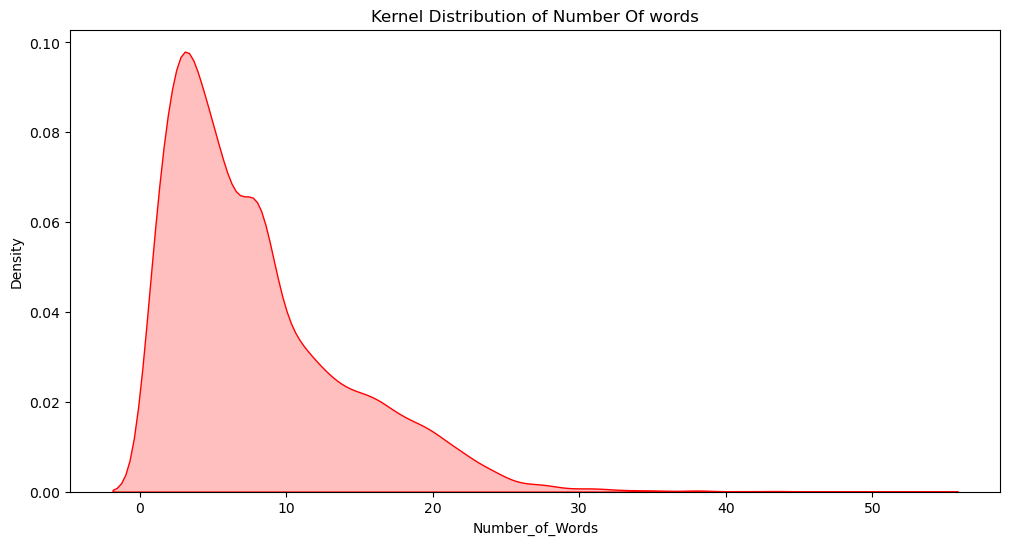

In [89]:
# to have an overview of the data
plt.figure(figsize=(12,6))
p1=sns.kdeplot(processed_df['Number_of_Words'], fill=True, color="r").set_title('Kernel Distribution of Number Of words')

We can see that overall, useful number of words in each tweet is quite small

In [90]:
processed_df['Number_of_Words'].describe()

count    10306.000000
mean         7.914031
std          6.024693
min          1.000000
25%          3.000000
50%          6.000000
75%         11.000000
max         53.000000
Name: Number_of_Words, dtype: float64

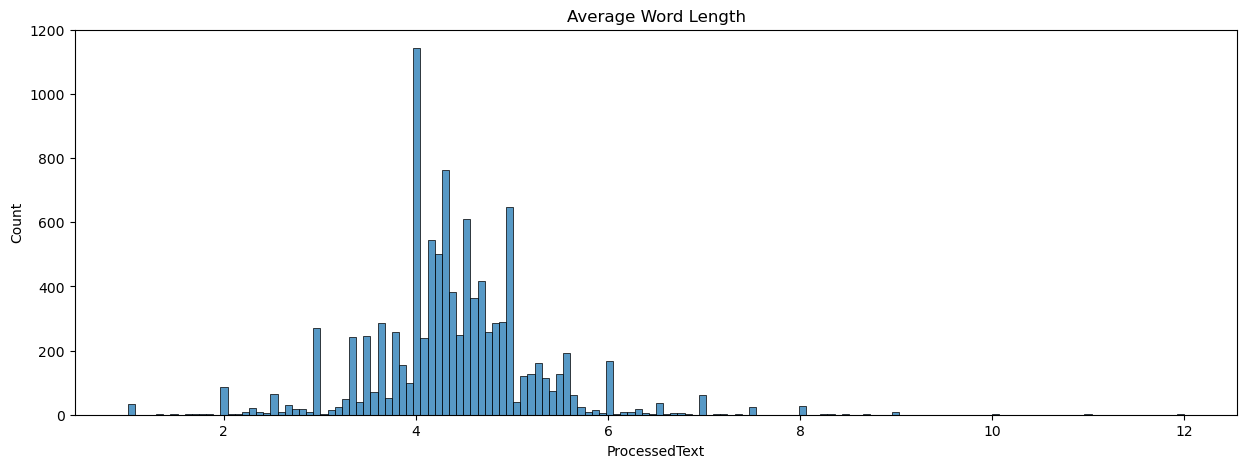

In [92]:
#compute the average length of words for each tweet
mean_word_len = processed_df['ProcessedText'].apply(lambda x : np.mean([len(i) for i in x]))
#plot the distribution of the average length of words
fig = plt.figure(figsize=(15, 5))
sns.histplot(data=mean_word_len)
plt.title("Average Word Length")
plt.show()

In [93]:
top = Counter([item for sublist in processed_df['ProcessedText'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,game,3245
1,b,2018
2,play,1675
3,team,1178
4,lost,1072
5,ark,1043
6,fortress,1028
7,get,1006
8,like,980
9,time,836


In [102]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()

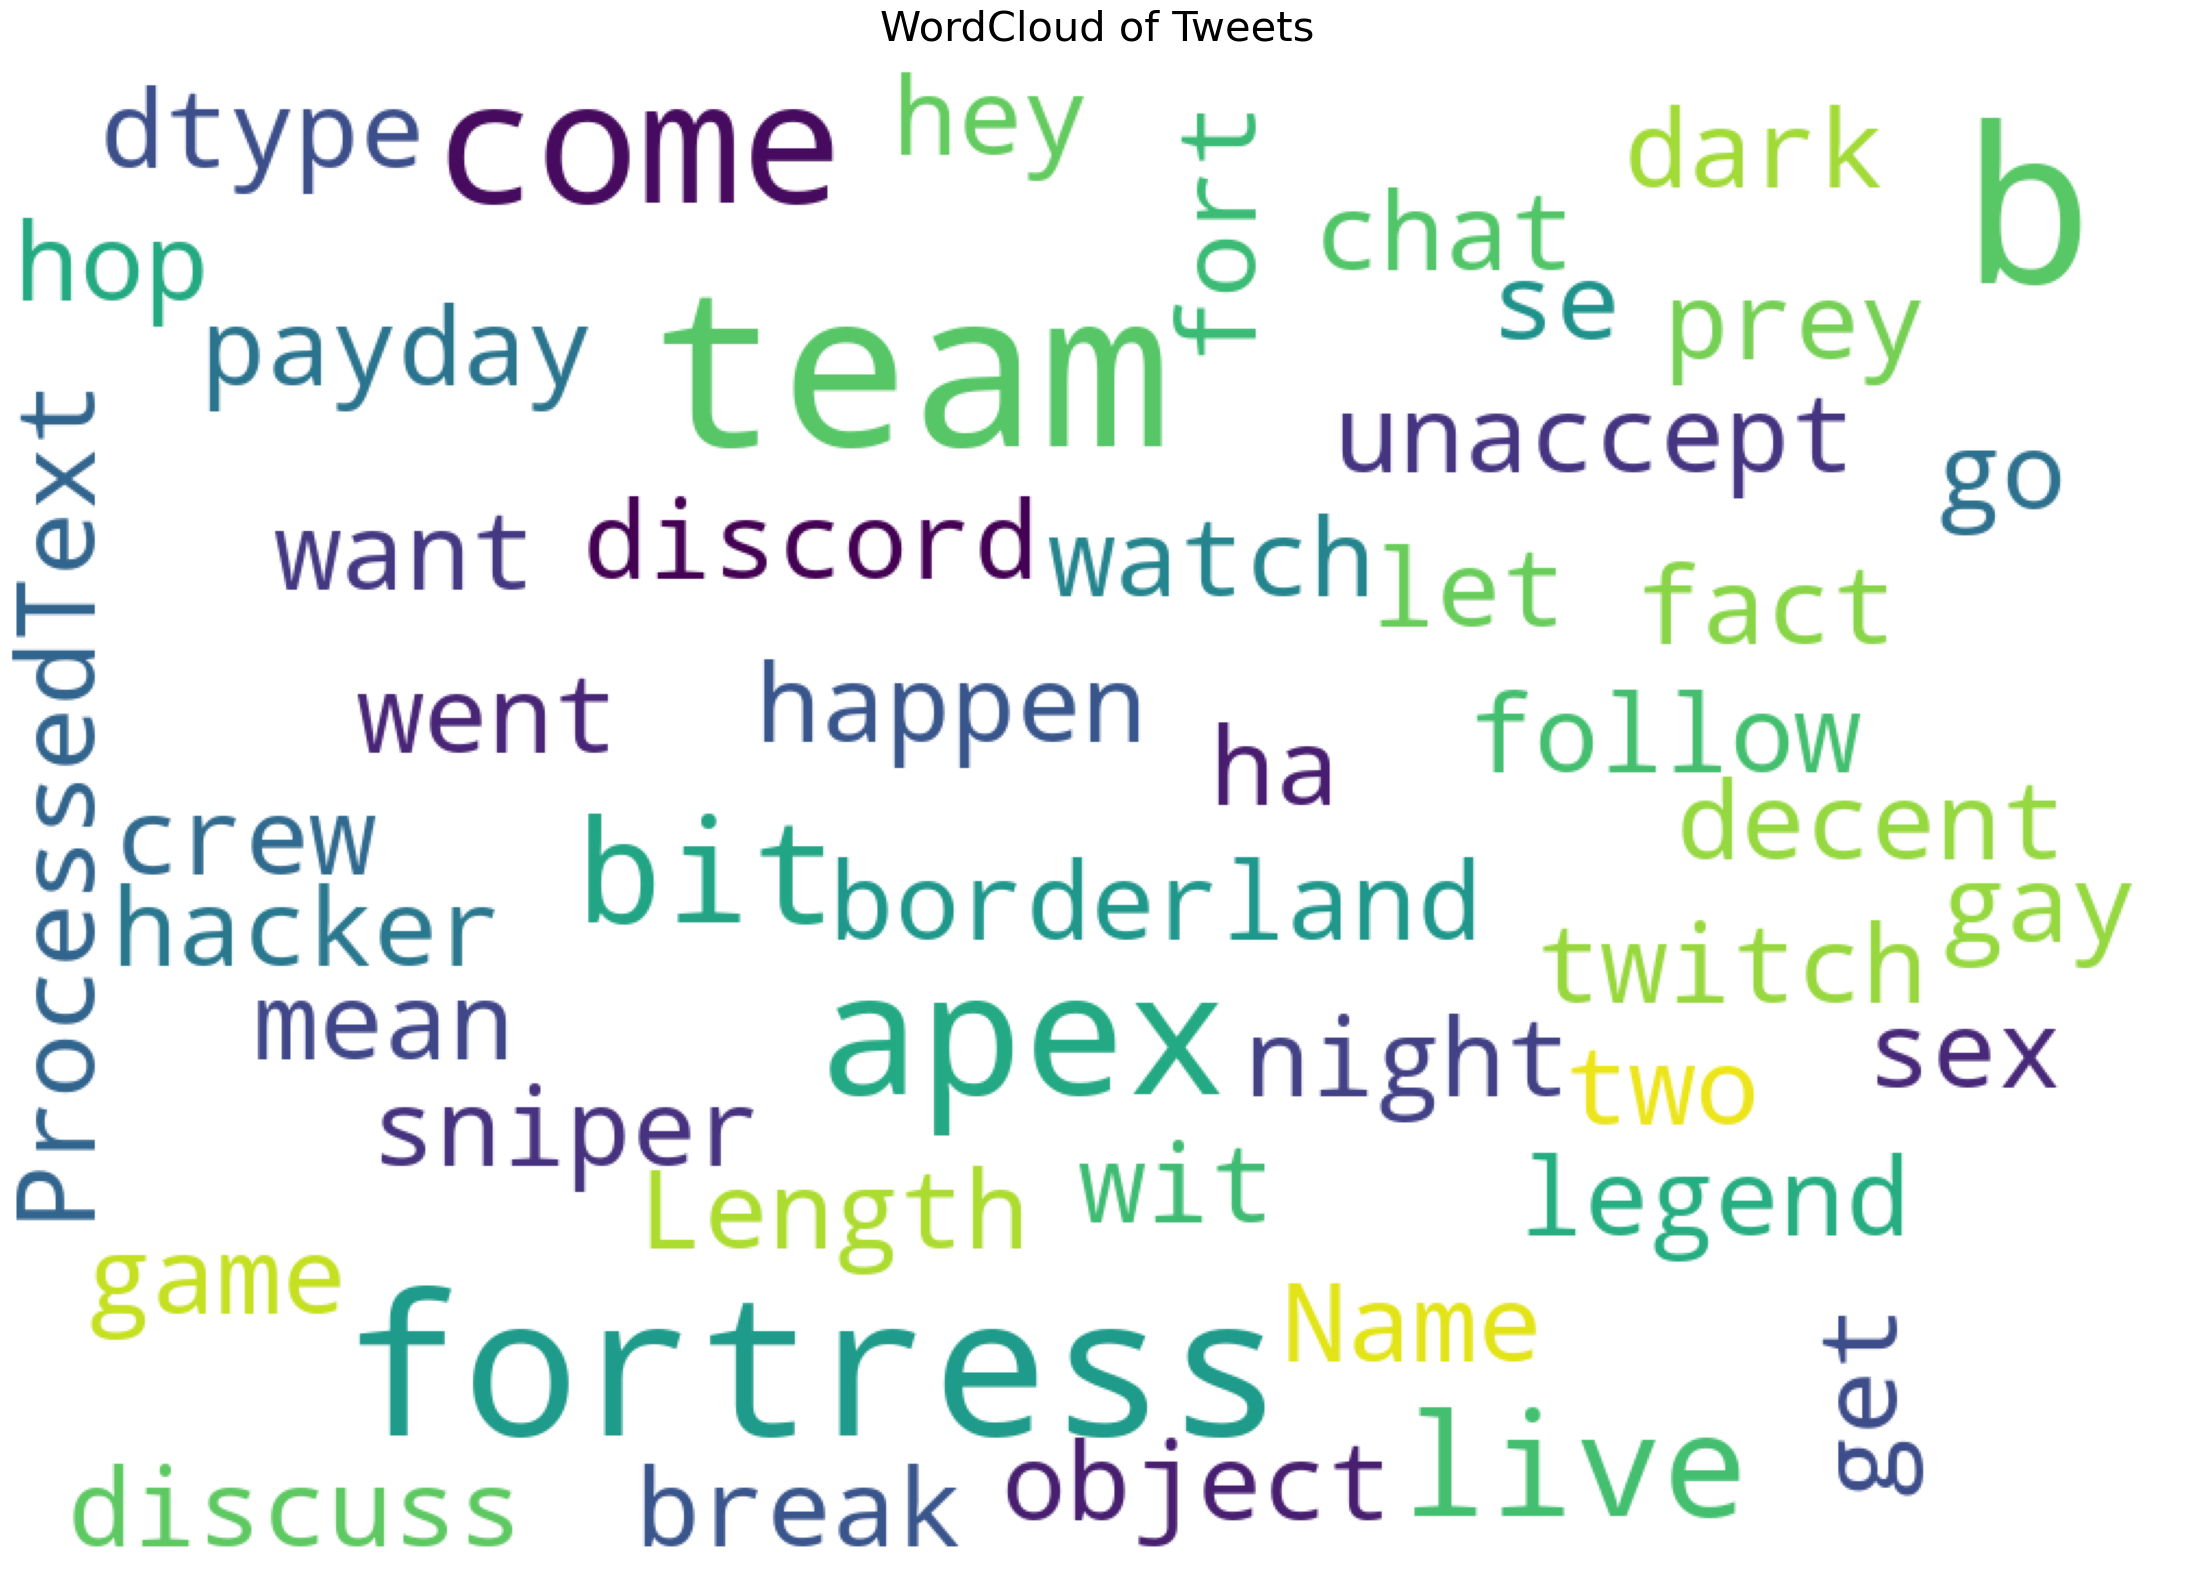

In [117]:
pos_mask = np.array(Image.new('RGB', (1000,700)))
plot_wordcloud(processed_df.ProcessedText,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Tweets")

#  2.Text Representation

Under this section, we are going to explore various ways of representing the text as matrix. Processed data will be saved for later experiments